In [55]:
import re
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score

In [56]:
def text_processing(messages, max_features = None):
    corpus = []
    for m in messages:
        if pd.notnull(m):
            corpus.append(re.sub(r"\b\d+\b|![:alpha:]|\d|\W|_|\b\w{1,2}\b", " ", m).lower())
        else:
            corpus.append(" ")
    if max_features is not None:
        vectorizer = CountVectorizer(strip_accents = 'ascii', 
                                     stop_words=['english'], 
                                     max_features = max_features)
    else:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words=['english'])
    vcorpus = vectorizer.fit_transform(corpus)
    labels = vectorizer.get_feature_names()
    return vcorpus, labels

def score(x):
    if x>2:
        return 3
    elif x>1:
        return 2
    elif x>0:
        return 1
    else:
        return 0
    
def summary( clf, X_test, y_test):
    print('       Accuracy Score: %.3f' % clf.score(X_test, y_test))
    print('     Model Best Score: %.3f' % clf.best_score_)
    print('Best Parameters Set: %s\n' % clf.best_params_)
    print('-------- Best Estimator -------- \n%s' % clf.best_estimator_)

def model_metrics(clf, X_test, y_test, cv=5):
    y_pred = cross_val_predict(clf, X_test, y_test, cv=cv)
    best_score_ = cross_val_score(clf, X_test, y_test, cv=cv).mean()
    cmatrix = confusion_matrix(y_test, y_pred)
    score = f1_score(y_test, y_pred, average='macro')
    metrics = {'score': score,
               'cv_score':best_score_,
               'confusion_matrix': cmatrix,
               'y_pred': y_pred}
    return metrics

In [17]:
issues = pd.read_csv('data/issues.csv',sep="|",na_filter=False)
#issues.to_csv("data/issues.csv",encoding='utf-8', index=False, sep="|")

In [18]:
issues.head()

,uuid,pooled_responses,pooled_score,score_class
0,018c3299txwr2qqp,Being able to be close enough to read the bott...,1.0,1
1,0207ygcsk0gjmpef,the screen wanted to turn left and right inste...,1.0,1
2,022uf3su0gk79gsk,Nothing They lots of stock and different kind ...,0.0,0
3,038dfe6hjbzkt34k,none yes,0.0,0
4,049f46tkcabh8cfc,NONE IT HAD MANY TYPES THE COLOR OF THE BOTTL...,0.0,0


In [19]:
X = responses = issues.pooled_responses
y = issues.score_class.as_matrix()

In [7]:
vcorpus, labels = text_processing(X)
X, y = vcorpus.toarray(), issues.score_class.as_matrix()
y = label_binarize(y, classes=[0, 1, 2, 3])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,  test_size=0.25)

In [ ]:
model = LinearSVC(C=1)
model.fit(X_train, y_train)
feature_selection = SelectFromModel(model, prefit=True)
X_train = feature_selection.transform(X_train)
X_test = feature_selection.transform(X_test)

In [13]:
clf = OneVsRestClassifier(LinearSVC(C=1))
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.79267624164017103

### Issues Text Classification - Calculate ROC

In [15]:
y_score = clf.fit(X_train, y_train).decision_function(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### ROC Plot

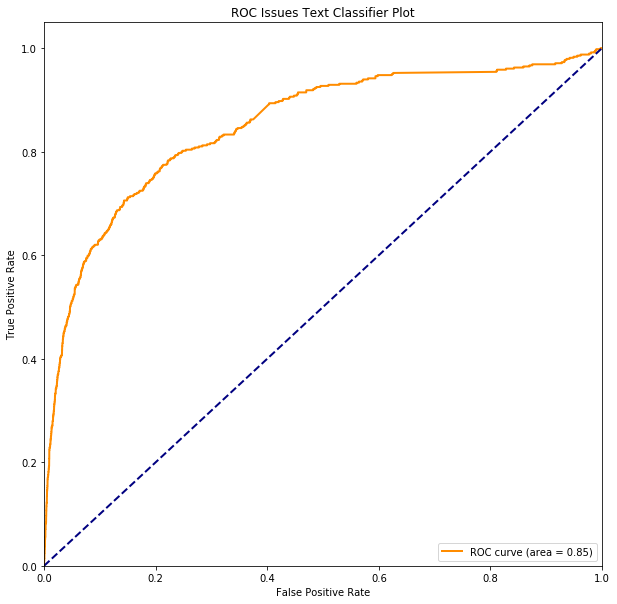

In [24]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Issues Text Classifier Plot')
plt.legend(loc="lower right")
plt.show()

### Compute macro-average ROC curve and ROC area

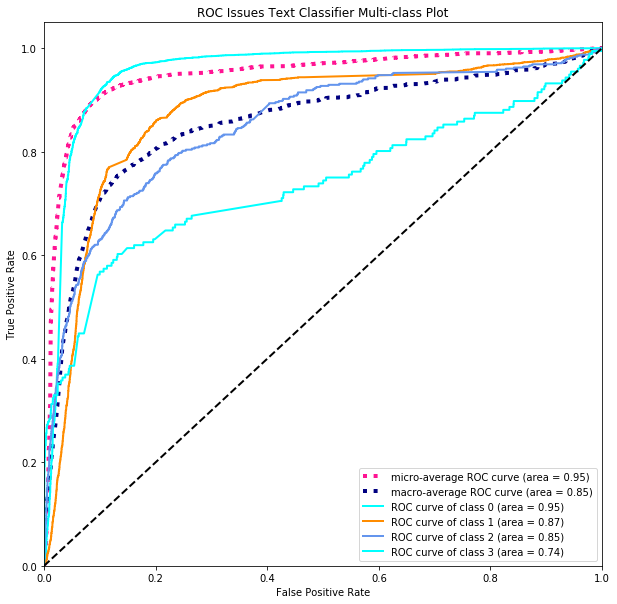

In [25]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Issues Text Classifier Multi-class Plot')
plt.legend(loc="lower right")
plt.show()

### Pipeline - Text Processing - LinearSVC

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC

In [26]:
params_svm = {'vect__ngram_range': [ (1,2), (1,3)],
               'tfidf__use_idf': (True, False),
               'svm_clf__C': ( .5, 1, 5),
               'svm_clf__class_weight': (None, "balanced"),
               
 }

svm_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,3), lowercase=True)),
        ('tfidf', TfidfTransformer(use_idf=False)),
        ("svm_clf", LinearSVC(C=1, loss='hinge', class_weight='balanced'))
    ])

In [28]:
gs_svm = GridSearchCV(svm_clf,  params_svm,  n_jobs=-1)
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip...inge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=1, tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 2), (1, 3)], 'tfidf__use_idf': (True, False), 'svm_clf__C': (0.5, 1, 5), 'svm_clf__class_weight': (None, 'balanced')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
summary(gs_svm, X_test, y_test)

        Accuracy Score: 0.867
Cross Validation Score: 0.862
   Best Parameters Set: {'svm_clf__C': 1, 'svm_clf__class_weight': None, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 3)}

-------- Best Estimator -------- 
Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip...inge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=1, tol=0.0001, verbose=0))])


In [57]:
metrics_svm = model_metrics(gs_svm,X_test, y_test, cv=5)

In [64]:
print('              F1 Score: {}'.format(metrics_svm['score']))
print('Cross Validation Score: {}\n'.format(metrics_svm['cv_score']))
print('-------- Confusion Matrix --------\n')
print(metrics_svm['confusion_matrix'])

              F1 Score: 0.5113863353258231
Cross Validation Score: 0.8556041089798467

-------- Confusion Matrix --------

[[5138  271    2    1]
 [ 415 2631    7    1]
 [  43  430    6    0]
 [  51   95    1   29]]
